In [177]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


In [178]:
# Load dataset and filter for wildfire-exposed regions with complete data
data = pd.read_csv("/Users/nzaramakouadio/Documents/Duke Classes/Spring 2025/ML/IDS705_MachineLearning_Project/10_Data_Clean/xgboost_data.csv") # add your directory for the data

In [179]:
data.head(3)

,Median_Household_Income,Total_Population,PRICE,Avg_Household_Size,Gini_Index,ZIP_CODE,YEAR,Employment_Rate,Below_Poverty_Rate,Rate_College_or_Higher,...,NEXT_YEAR_PRICE,PRICE_CHANGE,PCT_PRICE_CHANGE (%),ROLLING_1yr_PRICE_CHANGE,HOME_PRICE_LAG1,PRICE_CHANGE_LAG1,PRICE_CHANGE_DIFF,PREV_MAX_PCT_ZIP_BURNED,FIRE_LAST_YEAR,FIRE_SHOCK
0,35658.0,54480,263100.0,4.24,0.4056,90001,2012,89.369276,30.632127,16.684648,...,249600.0,-13500.0,-5.131129,NaN,NaN,NaN,NaN,0.0,0,0
1,35097.0,54760,249600.0,4.23,0.4108,90001,2013,87.745738,32.055698,17.057243,...,241800.0,-7800.0,-3.125000,-5.131129,263100.0,-13500.0,5700.0,0.0,0,0
2,34050.0,56314,241800.0,4.22,0.4181,90001,2014,87.023960,33.644361,18.102684,...,258500.0,16700.0,6.906534,-3.125000,249600.0,-7800.0,24500.0,0.0,0,0


In [180]:
data.columns

Index(['Median_Household_Income', 'Total_Population', 'PRICE',
       'Avg_Household_Size', 'Gini_Index', 'ZIP_CODE', 'YEAR',
       'Employment_Rate', 'Below_Poverty_Rate', 'Rate_College_or_Higher',
       'Black_Portion', 'White_Portion',
       'American_Indian_and_Alaska_Native_Portion', 'Asian_Portion',
       'NUM_FIRES', 'TOTAL_ACRES_BURNED_IN_ZIP', 'AVG_FIRE_DURATION_DAYS',
       'MAX_PCT_ZIP_BURNED', 'ANY_MAJOR_FIRE', 'FIRE_EXPOSED',
       'NEXT_YEAR_PRICE', 'PRICE_CHANGE', 'PCT_PRICE_CHANGE (%)',
       'ROLLING_1yr_PRICE_CHANGE', 'HOME_PRICE_LAG1', 'PRICE_CHANGE_LAG1',
       'PRICE_CHANGE_DIFF', 'PREV_MAX_PCT_ZIP_BURNED', 'FIRE_LAST_YEAR',
       'FIRE_SHOCK'],
      dtype='object')

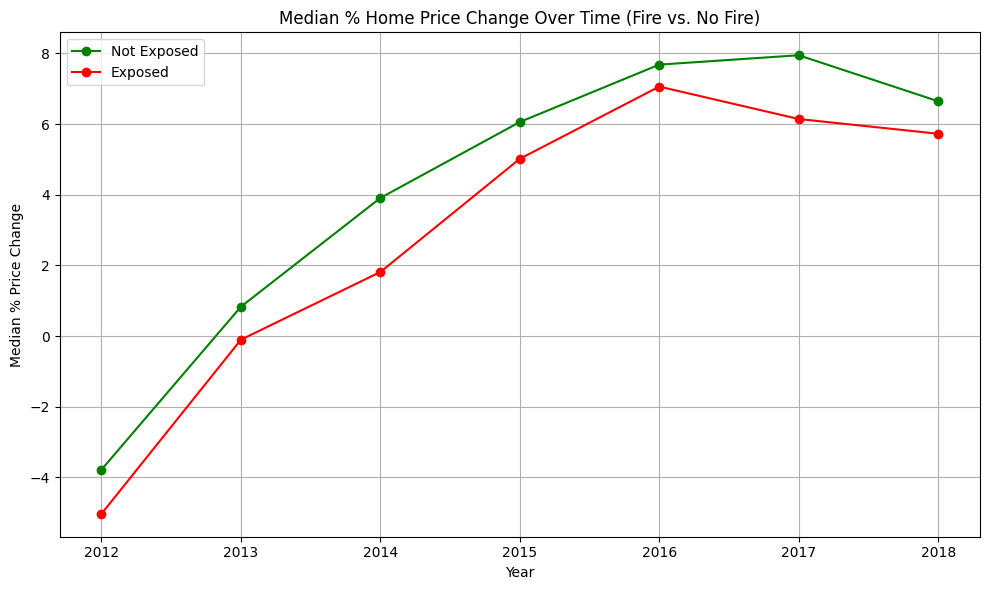

In [181]:
########################################################## Create a line plot showing average % price change per year, comparing ZIP codes ############################################


# Step 1: Group by YEAR and FIRE_EXPOSED, take mean of percent price change
avg_price_change = data.groupby(['YEAR', 'FIRE_EXPOSED'])['PCT_PRICE_CHANGE (%)'].median().reset_index()

# Step 2: Pivot table
pivot_df = avg_price_change.pivot(index='YEAR', columns='FIRE_EXPOSED', values='PCT_PRICE_CHANGE (%)')

# Step 3: Plot with explicit conversion to numpy arrays
plt.figure(figsize=(10, 6))
plt.plot(pivot_df.index.to_numpy(), pivot_df[0].to_numpy(), label='Not Exposed', marker='o', color='green')
plt.plot(pivot_df.index.to_numpy(), pivot_df[1].to_numpy(), label='Exposed', marker='o', color='red')
plt.title('Median % Home Price Change Over Time (Fire vs. No Fire)')
plt.xlabel('Year')
plt.ylabel('Median % Price Change')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


For each year (2012–2018), it plots the median percentage change in home prices for:
ZIP codes not exposed to fire (green line)
ZIP codes exposed to fire (red line)
What to notice:

Home prices are rising in both groups, but:
The red line (exposed) tends to grow more slowly — i.e., wildfires may dampen home price appreciation.

      Not Exposed  Exposed  Difference (Not - Exposed)
YEAR                                                  
2012        -3.78    -5.03                        1.25
2013         0.83    -0.10                        0.93
2014         3.91     1.81                        2.10
2015         6.06     5.02                        1.04
2016         7.69     7.06                        0.62
2017         7.95     6.14                        1.81
2018         6.65     5.73                        0.92


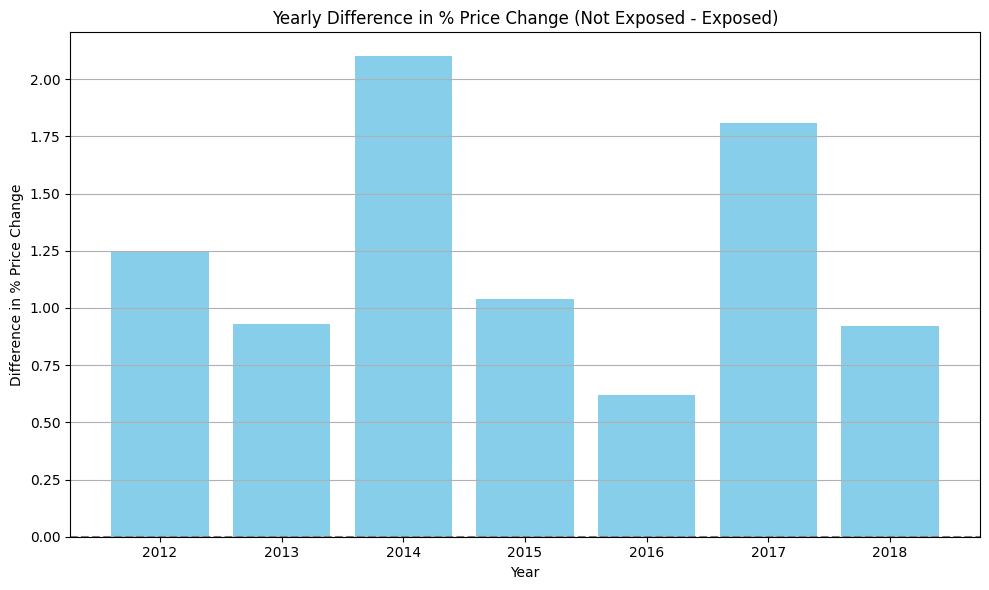

In [182]:
########################### Summary Table of Differences Per Year #############################

# Step 1: Group by year and exposure, and calculate the mean price change
grouped = data.groupby(['YEAR', 'FIRE_EXPOSED'])['PCT_PRICE_CHANGE (%)'].median().unstack()

# Step 2: Rename columns for clarity
grouped.columns = ['Not Exposed', 'Exposed']

# Step 3: Create a new column for the difference
grouped['Difference (Not - Exposed)'] = grouped['Not Exposed'] - grouped['Exposed']

# Step 4: Optional - Round the results for presentation
summary_table = grouped.round(2)

print(summary_table)

############################# Visualise the difference with a bar chart #############################

# Make sure YEAR is the index
summary_table.reset_index(inplace=True)

plt.figure(figsize=(10, 6))
plt.bar(summary_table['YEAR'], summary_table['Difference (Not - Exposed)'], color='skyblue')
plt.axhline(0, color='gray', linestyle='--')

plt.title('Yearly Difference in % Price Change (Not Exposed - Exposed)')
plt.xlabel('Year')
plt.ylabel('Difference in % Price Change')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


For each year, the difference in price growth between not-exposed and exposed ZIPs:
`Difference = Median Price Change (Not Exposed) − Median Price Change (Exposed)`

What to notice:

All bars are positive, meaning non-exposed ZIPs had higher price growth every year.
The difference peaked in 2014 (2.11%), suggesting that year had the strongest fire-related negative impact on housing prices.
